# CNN-LSTM on IAM lines

## Main Resources

- <a id="1">[1]</a> https://github.com/Sagar-modelling/Handwriting_Recognition_CRNN_LSTM
    - Recognizes words     
    - uses a wrapper model to find ctc loss
    - input: (128px,32px), output: sequence of max. 31 characters
    - kinda clear workflow and explanation
- <a id="2">[2]</a> https://github.com/sushant097/Handwritten-Line-Text-Recognition-using-Deep-Learning-with-Tensorflow
    - Recognizes lines of text
    - input: (800px,64px), output: sequence of max 100(?) characters
    - but it's tf v1    
- <a id="3">[3]</a> https://stackoverflow.com/questions/60285167/tensorflow-callback-as-custom-metric-for-ctc
    - CER & WER metrics implemented

## Replicate the process

Let's import some libs and define some constants

In [1]:
import cv2, os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

2024-02-17 19:08:03.240278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 19:08:03.240380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 19:08:03.408980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
characters = " !\"#%&'()*+,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" # +"ĂÂÎȘȚăâîșț"
dataset_path = "/kaggle/input/flex-iam-lines/IAM_lines/"

IMG_SIZE = (64, 800)
SEQ_LEN = 100
np.random.seed(2024)

- ```IMG_SIZE``` is the size of the input images into the network
- ```SEQ_LEN``` is the maximum number of characters that we assume exist on a single line

### Fetching dataset

We are using a customly organized version of the IAM dataset. It consists of a collection of paired files (`n.png`, `n.txt`), where `n` is a natural number. `n.png` is an image containing the cropped line and `n.txt` represents the text written on that line.

In [3]:
"""
Converts a string to an array of labels.
Each character is mapped to an integer label that marks its 
position in the `characters` string.
The resulted array is padded up to `SEQ_LEN` with a constant 
value (has the same value with the so-called "CTC blank label").
"""
def text_to_labels(text:str):
    char_ids = []
    for c in text:
        cid = characters.find(c)
        if cid<0:
            print(f"Warning: undefined character `{c}`")
        else:
            char_ids.append(cid)
    while(len(char_ids)<SEQ_LEN):
        char_ids.append(len(characters))
    return np.array(char_ids)    

In [4]:
"""
Resizes an image to fit into the `IMG_SIZE` bounds, attempting 
to keep aspect ratio if the input is not too wide.
"""
def im_resize(img):
    h, w = img.shape
    H, W = IMG_SIZE
    new_img = cv2.resize(img, (w*H//h, H), interpolation=cv2.INTER_CUBIC)    
    if new_img.shape[1] < W:
        new_img = np.pad(new_img, ((0,0), (0, W - new_img.shape[1])), mode="maximum")
    elif new_img.shape[1] > W:
        new_img = cv2.resize(new_img, (W, H))
    return new_img

In [5]:
"""
Increases constrast and makes lines thicker in an image
"""
def enhance(img):
    pxmin = np.min(img)
    pxmax = np.max(img)
    imgContrast = (img - pxmin) / (pxmax - pxmin) * 255    
    kernel = np.ones((3, 3), np.uint8)
    return cv2.erode(imgContrast, kernel, iterations=1) # increase linewidth

Now we're ready to load the dataset into memory.
- Plain loading as numpy arrays, no generators, no data augmentation for now
- `x_train[i]` represents the input image
- `y_true[i]` represents the (labeled) output of `x_train[i]`
- `y_len[i]` tells the number of (useful/effective) characters in `y_true[i]`, considering that the original strings were all padded up to the same length. This value is needed in computing the CTC loss and is also known as the **label length**

In [6]:
x_train, y_true, y_len = [], [], []

k = 0
for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        if name.endswith(".png"):            
            img = cv2.imread(os.path.join(root, name), cv2.IMREAD_GRAYSCALE)
            img = enhance(img)                                    
            img = im_resize(img)            
            img = np.reshape(img, IMG_SIZE+(1,))
            with open(os.path.join(root, name[:-4]+".txt"), "r") as f:
                txt = f.read()

            tlabels = text_to_labels(txt)        
            y_true.append(tlabels)
            y_len.append([len(txt)])
                       
            x_train.append(img/255.)

            k += 1
            print(f"\rLoaded {k} images", end="")

            #if k==100: break
print()

# "Seal" the lists into numpy arrays
x_train, y_true, y_len = np.array(x_train), np.array(y_true), np.array(y_len) 

Loaded 13353 images


In [7]:
# Shuffle data

def shuffle(arrs):
    l = arrs[0].shape[0]    
    ix = np.array(list(range(l)))        
    np.random.shuffle(ix)
    return tuple(map(lambda c:c[ix], arrs))    

x_train, y_true, y_len = shuffle([x_train, y_true, y_len])

x_train.shape, y_true.shape, y_len.shape

((13353, 64, 800, 1), (13353, 100), (13353, 1))

- We also need a dummy output value for the wrapper model, let's call it `y_train`. 

In [8]:
y_train = np.zeros(y_len.shape)
y_train.shape

(13353, 1)

### Input preview

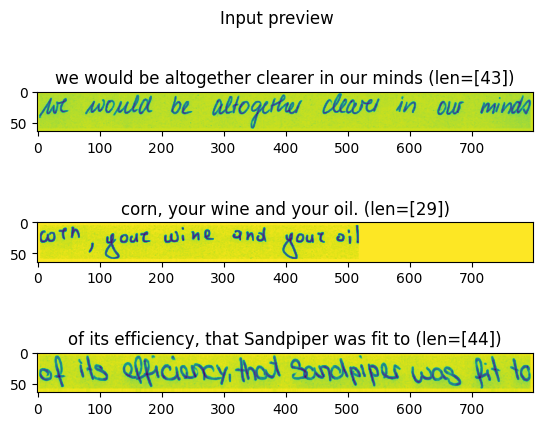

In [9]:
def preview_input(n=3):
    fig, axs = plt.subplots(n)
    fig.suptitle('Input preview')    

    for i in range(n):
        axs[i].imshow(x_train[i])
        text = "".join([characters[c] for c in y_true[i] if c<len(characters)])        
        axs[i].set_title(f"{text} (len={y_len[i]})")
    plt.show()

preview_input(3)

## Recognition model

The recognition model takes the input through a series of convolutional layers, before finally sending the features to a BiLSTM layer.

In [10]:
def create_recognition_model(img_size, labels_len):               
    x = x_input = tf.keras.layers.Input(shape=(*img_size, 1), name='x_input')
        
    x = tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(5,5), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)        
        
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)    
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)                    
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)        
    
    x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.01)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,1))(x)            
    
    # ----- LSTM -----        
    x = tf.keras.layers.Reshape((-1, 512))(x)      
    # the loss may become inf if we don't add more timestamps 
    x = tf.keras.layers.ZeroPadding1D(((0,28)))(x) 
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x)
    
    x = tf.keras.layers.Reshape((-1, 1, 1024))(x)
    x = tf.keras.layers.Conv2D(labels_len, kernel_size=(1,1))(x)        
    x = tf.keras.layers.Reshape((-1, labels_len))(x)
    x = tf.keras.layers.Softmax()(x)                
    
    return tf.keras.models.Model(x_input, x)    

In [83]:
recognition_model = create_recognition_model(IMG_SIZE, len(characters)+1)
recognition_model.summary(110)

Model: "model_4"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 x_input (InputLayer)                            [(None, 64, 800, 1)]                        0                
                                                                                                              
 conv2d_7 (Conv2D)                               (None, 64, 800, 64)                         1664             
                                                                                                              
 leaky_re_lu_6 (LeakyReLU)                       (None, 64, 800, 64)                         0                
                                                                                                              
 max_pooling2d_6 (MaxPooling2D)                  (None, 32, 400, 64)                         0 

- On the same note as `y_train`, we also need a new tensor that provides the number of timestamps for the CTC loss function. We name it `logit_len`

In [12]:
logit_len = np.full((x_train.shape[0], 1), recognition_model.outputs[0].shape[1])
"Tensor shape:", logit_len.shape, "Timestamps length:", logit_len[0][0]

('Tensor shape:', (13353, 1), 'Timestamps length:', 128)

### Training model

We follow the approach from [[1]](#1), where another model is created which incorporates the recognition model and applies the CTC loss on its output using a separate layer. The reason that leads to this complication resides in the fact that the function that computes the loss (namely `ctc_batch_cost`) needs some additional parameters besides the predicted output, like the label and logit length. Also, the real and predicted outputs have different shapes. This was solved by creating a separate layer for computing the loss function and providing the needed arguments as input layers to the network.


In [19]:
y_true_categorical = tf.keras.utils.to_categorical(y_true)
y_true_categorical.shape

(13353, 100, 82)

In [20]:
def create_train_model(model):
    x_input = tf.keras.layers.Input(shape=model.inputs[0].shape[1:], name='img')
    y_true = tf.keras.layers.Input(shape=(SEQ_LEN,), name='y_true')
    label_len = tf.keras.layers.Input(shape=(1,), name="label_len")    
    logits_len = tf.keras.layers.Input(shape=(1,), name="logits_len")      
    
    y_pred = model(x_input)       
    
    def ctc_layer(data):        
        y_true, y_pred, logit_len, label_len = data               
        return tf.keras.backend.ctc_batch_cost(y_true, y_pred, logit_len, label_len)

    ctc_out = tf.keras.layers.Lambda(ctc_layer, name="ctc")([y_true, y_pred, logits_len, label_len]) 
    
    pred_out = tf.keras.layers.Lambda(lambda x:x, name="pred")(y_pred)
    true_out = tf.keras.layers.Lambda(lambda x:x, name="true")(y_true)
    
    return tf.keras.models.Model([x_input, y_true, label_len, logits_len], [ctc_out, pred_out])    


In [84]:
train_model = create_train_model(recognition_model)

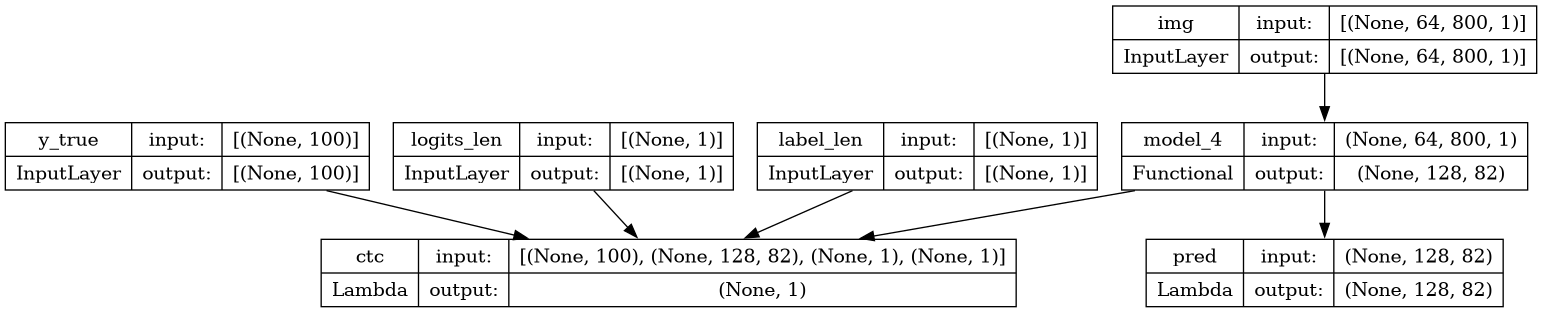

In [85]:
tf.keras.utils.plot_model(train_model, expand_nested=False, show_shapes=True)

The output of the last `Lambda "ctc"` layer will be test against `y_train` values during training. [[1]](#1), the loss function was written as ```lambda y_true, y_pred: y_pred``` (in the given circumstances, this does the same thing as the `MAE` loss, as the "groundtruth" value is always `0`). I also added a projection of the predicted data to compare with the original output, which was converted to a tensor which has the same shape as the output (`y_true_categorical`).

### CER & WER

In [90]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')

        paddings = tf.constant([[0,0],[0, 28],[0,0]])
        y_true = tf.pad(y_true, paddings, "CONSTANT", constant_values=len(characters))
        
        decode, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)
        y_true, log = tf.keras.backend.ctc_decode(y_true, input_length, greedy=True)

        decode = tf.keras.backend.ctc_label_dense_to_sparse(decode[0], tf.keras.backend.cast(input_length, 'int32'))
        y_true_sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true[0], tf.keras.backend.cast(input_length, 'int32'))                
        
        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(len(y_true))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [91]:
class WERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Word Error Rate
    """
    def __init__(self, name='WER_metric', **kwargs):
        super(WERMetric, self).__init__(name=name, **kwargs)
        self.wer_accumulator = self.add_weight(name="total_wer", initializer="zeros")
        self.counter = self.add_weight(name="wer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')
        
        paddings = tf.constant([[0,0],[0, 28],[0,0]])
        y_true = tf.pad(y_true, paddings, "CONSTANT", constant_values=len(characters))
        
        decode, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)
        y_true, log = tf.keras.backend.ctc_decode(y_true, input_length, greedy=True)

        decode = tf.keras.backend.ctc_label_dense_to_sparse(decode[0], tf.keras.backend.cast(input_length, 'int32'))
        y_true_sparse = tf.keras.backend.ctc_label_dense_to_sparse(y_true[0], tf.keras.backend.cast(input_length, 'int32'))                

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)
        
        correct_words_amount = tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32))

        self.wer_accumulator.assign_add(correct_words_amount)
        self.counter.assign_add(len(y_true))

    def result(self):
        return tf.math.divide_no_nan(self.wer_accumulator, self.counter)

    def reset_state(self):
        self.wer_accumulator.assign(0.0)
        self.counter.assign(0.0)

### Prepare for training



In [92]:
train_model.compile(optimizer="rmsprop", 
                    loss={
                        'ctc': lambda y_true, y_pred: y_pred                 
                    }, 
                    metrics={
                        'ctc':"accuracy",
                        'pred':[CERMetric(),WERMetric()]
                    })

Let's now define a callback function to be called at the end of each epoch. We are using it to regularly save the model and monitor the state of predictions

In [88]:
def callback_plot(epoch, logs):    
    if epoch%5==0:    
        n=1
        in_img = x_train[:n,:,:,:]
        in_true = y_true[:n,:]
        out_pred = recognition_model.predict(in_img) #tf.math.argmax(recognition_model.predict(in_img), axis=2)                    

        for i in range(n):        
            img = in_img[i]
            true = in_true[i]
            true = "".join([characters[c] for c in true if c<len(characters)])
            pred = out_pred[i]
            
        fig, axs = plt.subplots(2)
        fig.suptitle(true)        
        axs[0].imshow(img)
                
        print(pred.shape)
        
        def label2char(l): 
            c = characters[l] if l<len(characters) else "ε"
            if c==" ": c="\\s"
            return c
        
        for i in range(len(characters)+1):
            yc = pred[:,i]
            im = np.argmax(yc)            
            axs[1].plot(yc)   
            plt.text(im, yc[im], label2char(i))            
        
        plt.show()
            

    if epoch%3==0:
        recognition_model.save_weights("model_lstm_fullscale.h5")

### Training the model

Epoch 1/200
1/1 [==============================] - 0s 23ms/step- loss: 133.6662 - ctc_loss: 133.6662 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.9584 - pred_WER_metric: 3.00
(128, 82)


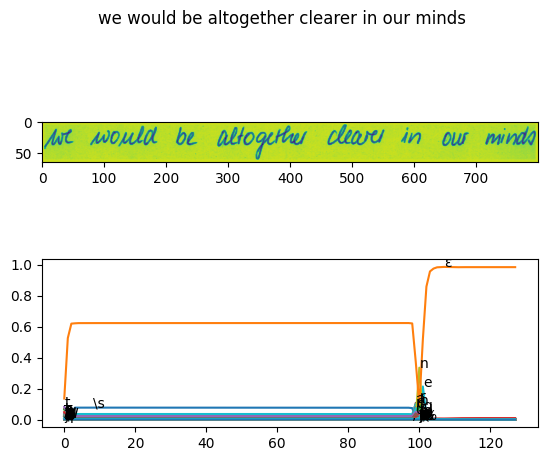

300/300 [==============================] - 24s 63ms/step - loss: 133.6662 - ctc_loss: 133.6662 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.9584 - pred_WER_metric: 3.0000 - val_loss: 133.7111 - val_ctc_loss: 133.7111 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.9200 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 2/200
300/300 [==============================] - 16s 55ms/step - loss: 133.4120 - ctc_loss: 133.4120 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.9578 - pred_WER_metric: 3.0000 - val_loss: 134.1042 - val_ctc_loss: 134.1042 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.9198 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 3/200
300/300 [==============================] - 16s 55ms/step - loss: 133.2702 - ctc_loss: 133.2702 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.9530 - pred_WER_metric: 3.0000 - val_loss: 143.9322 - val_ctc_loss: 143.9322 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.9000 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoc

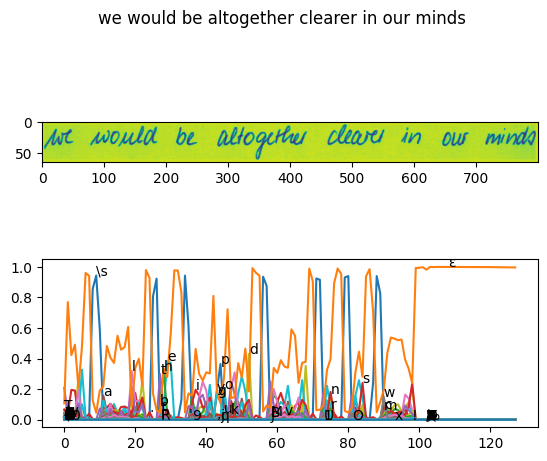

300/300 [==============================] - 17s 56ms/step - loss: 105.5240 - ctc_loss: 105.5240 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.7478 - pred_WER_metric: 3.0000 - val_loss: 97.2672 - val_ctc_loss: 97.2672 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.6503 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 7/200
300/300 [==============================] - 16s 55ms/step - loss: 90.9763 - ctc_loss: 90.9763 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.6413 - pred_WER_metric: 3.0000 - val_loss: 87.1990 - val_ctc_loss: 87.1990 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.5122 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 8/200
300/300 [==============================] - 16s 55ms/step - loss: 74.7334 - ctc_loss: 74.7334 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.5127 - pred_WER_metric: 3.0000 - val_loss: 69.6708 - val_ctc_loss: 69.6708 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.4152 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 9/200
30

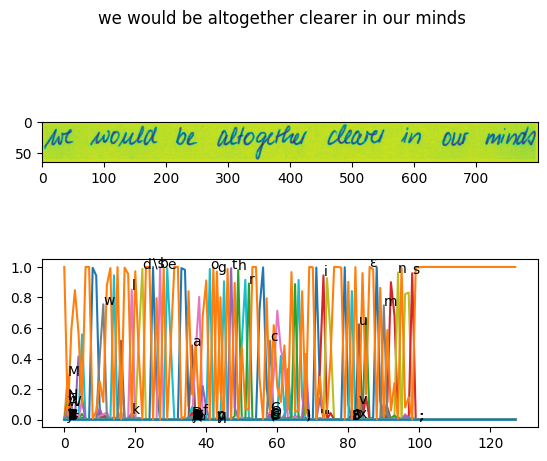

300/300 [==============================] - 17s 56ms/step - loss: 40.4368 - ctc_loss: 40.4368 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.2922 - pred_WER_metric: 3.0000 - val_loss: 40.7997 - val_ctc_loss: 40.7997 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2417 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 12/200
300/300 [==============================] - 16s 54ms/step - loss: 34.0042 - ctc_loss: 34.0042 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.2532 - pred_WER_metric: 3.0000 - val_loss: 48.0584 - val_ctc_loss: 48.0584 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2525 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 13/200
300/300 [==============================] - 16s 55ms/step - loss: 28.7854 - ctc_loss: 28.7854 - ctc_accuracy: 0.0000e+00 - pred_CER_metric: 2.2259 - pred_WER_metric: 3.0000 - val_loss: 40.9376 - val_ctc_loss: 40.9376 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2286 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 14/200
3

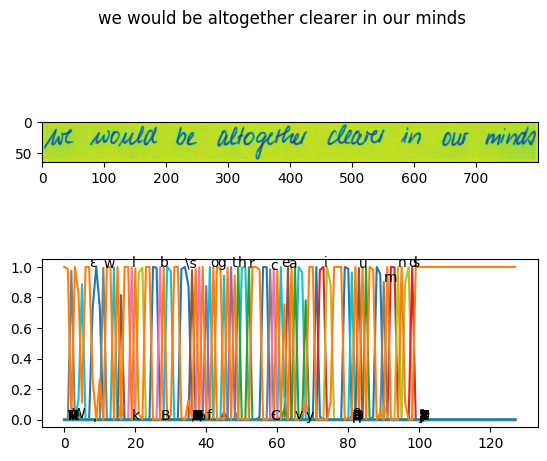

300/300 [==============================] - 17s 56ms/step - loss: 16.2476 - ctc_loss: 16.2476 - ctc_accuracy: 0.0022 - pred_CER_metric: 2.1540 - pred_WER_metric: 3.0000 - val_loss: 41.2607 - val_ctc_loss: 41.2607 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1962 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 17/200
300/300 [==============================] - 16s 54ms/step - loss: 13.3326 - ctc_loss: 13.3326 - ctc_accuracy: 0.0067 - pred_CER_metric: 2.1382 - pred_WER_metric: 3.0000 - val_loss: 41.5086 - val_ctc_loss: 41.5086 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2137 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 18/200
300/300 [==============================] - 16s 54ms/step - loss: 10.7979 - ctc_loss: 10.7979 - ctc_accuracy: 0.0222 - pred_CER_metric: 2.1209 - pred_WER_metric: 3.0000 - val_loss: 51.3519 - val_ctc_loss: 51.3519 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2167 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 19/200
300/300 [====

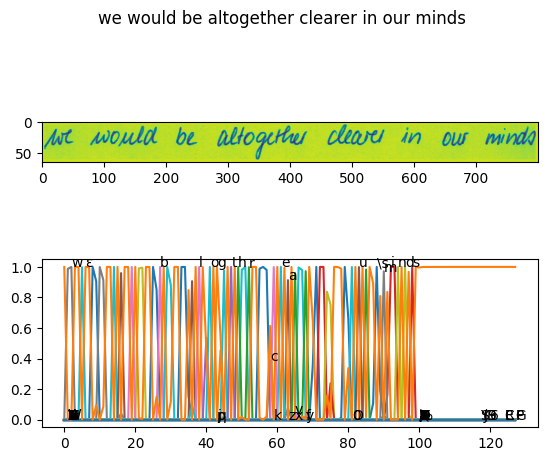

300/300 [==============================] - 17s 56ms/step - loss: 6.5697 - ctc_loss: 6.5697 - ctc_accuracy: 0.0622 - pred_CER_metric: 2.0965 - pred_WER_metric: 3.0000 - val_loss: 50.0734 - val_ctc_loss: 50.0734 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2125 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 22/200
300/300 [==============================] - 16s 54ms/step - loss: 5.6782 - ctc_loss: 5.6782 - ctc_accuracy: 0.0856 - pred_CER_metric: 2.0914 - pred_WER_metric: 3.0000 - val_loss: 53.9625 - val_ctc_loss: 53.9625 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2006 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 23/200
300/300 [==============================] - 16s 54ms/step - loss: 4.9341 - ctc_loss: 4.9341 - ctc_accuracy: 0.1122 - pred_CER_metric: 2.0860 - pred_WER_metric: 3.0000 - val_loss: 56.2196 - val_ctc_loss: 56.2196 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1997 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 24/200
300/300 [==========

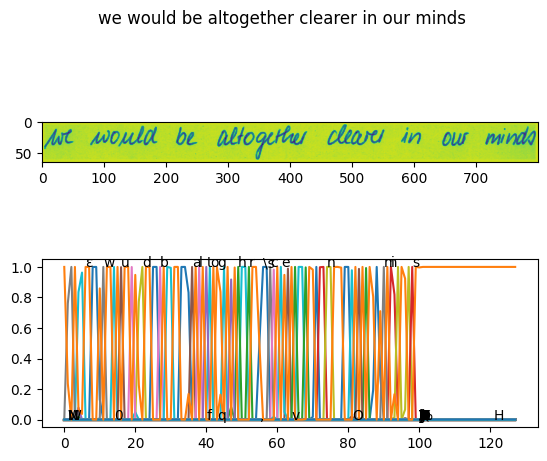

300/300 [==============================] - 17s 56ms/step - loss: 3.6776 - ctc_loss: 3.6776 - ctc_accuracy: 0.1900 - pred_CER_metric: 2.0783 - pred_WER_metric: 3.0000 - val_loss: 60.1553 - val_ctc_loss: 60.1553 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.2052 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 27/200
300/300 [==============================] - 16s 54ms/step - loss: 3.4656 - ctc_loss: 3.4656 - ctc_accuracy: 0.1956 - pred_CER_metric: 2.0782 - pred_WER_metric: 3.0000 - val_loss: 59.6600 - val_ctc_loss: 59.6600 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1937 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 28/200
300/300 [==============================] - 16s 55ms/step - loss: 3.1310 - ctc_loss: 3.1310 - ctc_accuracy: 0.2589 - pred_CER_metric: 2.0750 - pred_WER_metric: 3.0000 - val_loss: 61.8233 - val_ctc_loss: 61.8233 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2165 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 29/200
300/300 [==============

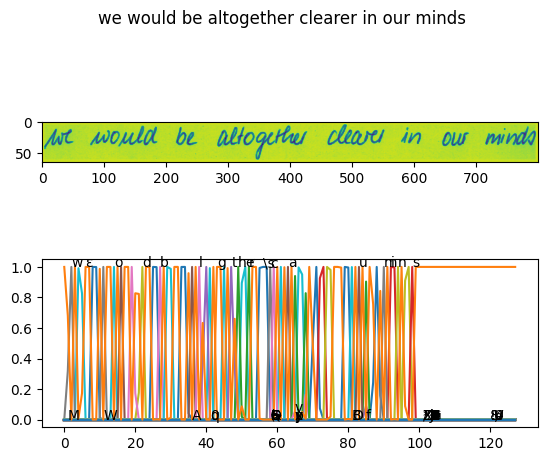

300/300 [==============================] - 17s 56ms/step - loss: 2.6373 - ctc_loss: 2.6373 - ctc_accuracy: 0.2856 - pred_CER_metric: 2.0708 - pred_WER_metric: 3.0000 - val_loss: 60.7260 - val_ctc_loss: 60.7260 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1965 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 32/200
300/300 [==============================] - 16s 54ms/step - loss: 2.4133 - ctc_loss: 2.4133 - ctc_accuracy: 0.3544 - pred_CER_metric: 2.0705 - pred_WER_metric: 3.0000 - val_loss: 57.5701 - val_ctc_loss: 57.5701 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2015 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 33/200
300/300 [==============================] - 16s 54ms/step - loss: 2.3422 - ctc_loss: 2.3422 - ctc_accuracy: 0.3500 - pred_CER_metric: 2.0703 - pred_WER_metric: 3.0000 - val_loss: 61.2485 - val_ctc_loss: 61.2485 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2144 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 34/200
300/300 [==========

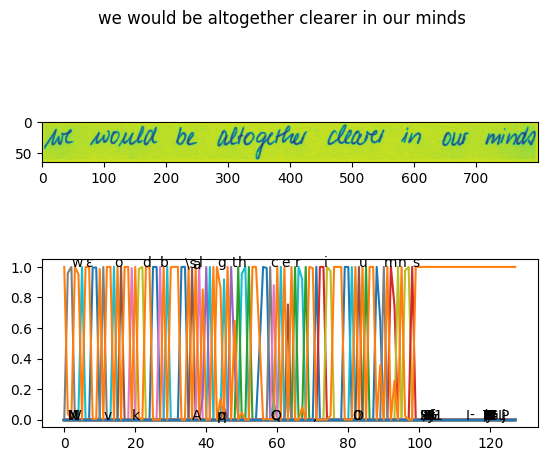

300/300 [==============================] - 17s 56ms/step - loss: 2.0525 - ctc_loss: 2.0525 - ctc_accuracy: 0.4244 - pred_CER_metric: 2.0678 - pred_WER_metric: 3.0000 - val_loss: 62.2481 - val_ctc_loss: 62.2481 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1886 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 37/200
300/300 [==============================] - 16s 54ms/step - loss: 1.9743 - ctc_loss: 1.9743 - ctc_accuracy: 0.4156 - pred_CER_metric: 2.0679 - pred_WER_metric: 3.0000 - val_loss: 64.5999 - val_ctc_loss: 64.5999 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1886 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 38/200
300/300 [==============================] - 16s 55ms/step - loss: 1.7442 - ctc_loss: 1.7442 - ctc_accuracy: 0.4622 - pred_CER_metric: 2.0661 - pred_WER_metric: 3.0000 - val_loss: 60.1250 - val_ctc_loss: 60.1250 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1896 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 39/200
300/300 [==========

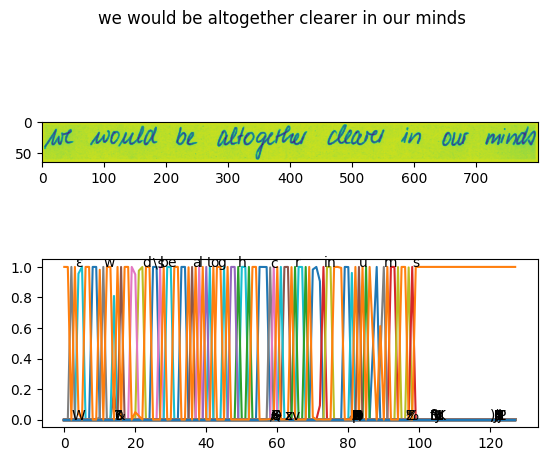

300/300 [==============================] - 17s 56ms/step - loss: 1.7188 - ctc_loss: 1.7188 - ctc_accuracy: 0.4811 - pred_CER_metric: 2.0664 - pred_WER_metric: 3.0000 - val_loss: 66.1018 - val_ctc_loss: 66.1018 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1914 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 42/200
300/300 [==============================] - 16s 54ms/step - loss: 1.6769 - ctc_loss: 1.6769 - ctc_accuracy: 0.4922 - pred_CER_metric: 2.0653 - pred_WER_metric: 3.0000 - val_loss: 66.2844 - val_ctc_loss: 66.2844 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1937 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 43/200
300/300 [==============================] - 16s 55ms/step - loss: 1.6556 - ctc_loss: 1.6556 - ctc_accuracy: 0.5056 - pred_CER_metric: 2.0650 - pred_WER_metric: 3.0000 - val_loss: 70.4334 - val_ctc_loss: 70.4334 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1909 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 44/200
300/300 [==========

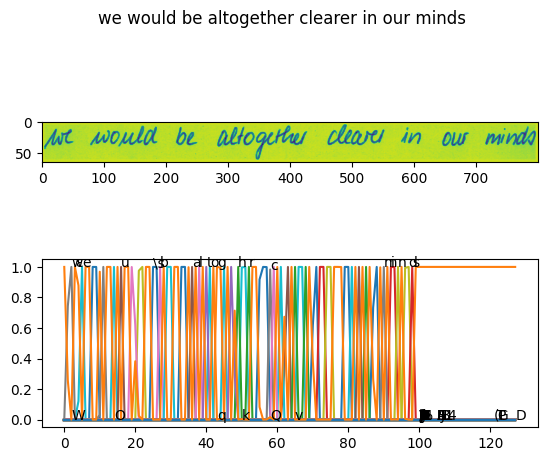

300/300 [==============================] - 17s 56ms/step - loss: 1.6943 - ctc_loss: 1.6943 - ctc_accuracy: 0.5044 - pred_CER_metric: 2.0660 - pred_WER_metric: 3.0000 - val_loss: 67.5944 - val_ctc_loss: 67.5944 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1836 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 47/200
300/300 [==============================] - 16s 55ms/step - loss: 1.4212 - ctc_loss: 1.4212 - ctc_accuracy: 0.5322 - pred_CER_metric: 2.0643 - pred_WER_metric: 3.0000 - val_loss: 72.3547 - val_ctc_loss: 72.3547 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1905 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 48/200
300/300 [==============================] - 16s 54ms/step - loss: 1.4611 - ctc_loss: 1.4611 - ctc_accuracy: 0.5711 - pred_CER_metric: 2.0638 - pred_WER_metric: 3.0000 - val_loss: 70.1456 - val_ctc_loss: 70.1456 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1937 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 49/200
300/300 [==============

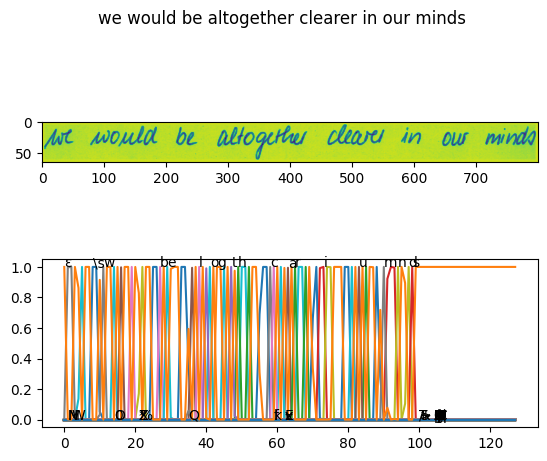

300/300 [==============================] - 18s 59ms/step - loss: 1.4321 - ctc_loss: 1.4321 - ctc_accuracy: 0.5733 - pred_CER_metric: 2.0640 - pred_WER_metric: 3.0000 - val_loss: 69.7954 - val_ctc_loss: 69.7954 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1866 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 52/200
300/300 [==============================] - 16s 55ms/step - loss: 1.4672 - ctc_loss: 1.4672 - ctc_accuracy: 0.5867 - pred_CER_metric: 2.0643 - pred_WER_metric: 3.0000 - val_loss: 67.3338 - val_ctc_loss: 67.3338 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1882 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 53/200
300/300 [==============================] - 16s 54ms/step - loss: 1.3231 - ctc_loss: 1.3231 - ctc_accuracy: 0.5811 - pred_CER_metric: 2.0636 - pred_WER_metric: 3.0000 - val_loss: 71.2802 - val_ctc_loss: 71.2802 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1946 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 54/200
300/300 [==============

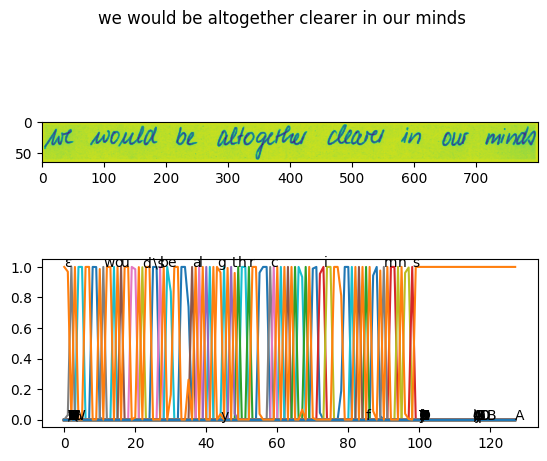

300/300 [==============================] - 17s 56ms/step - loss: 1.3204 - ctc_loss: 1.3204 - ctc_accuracy: 0.6089 - pred_CER_metric: 2.0623 - pred_WER_metric: 3.0000 - val_loss: 72.6845 - val_ctc_loss: 72.6845 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1827 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 57/200
300/300 [==============================] - 16s 54ms/step - loss: 1.1351 - ctc_loss: 1.1351 - ctc_accuracy: 0.6311 - pred_CER_metric: 2.0624 - pred_WER_metric: 3.0000 - val_loss: 69.0502 - val_ctc_loss: 69.0502 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1882 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 58/200
300/300 [==============================] - 16s 55ms/step - loss: 1.1068 - ctc_loss: 1.1068 - ctc_accuracy: 0.6656 - pred_CER_metric: 2.0615 - pred_WER_metric: 3.0000 - val_loss: 68.8163 - val_ctc_loss: 68.8163 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1900 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 59/200
300/300 [==================

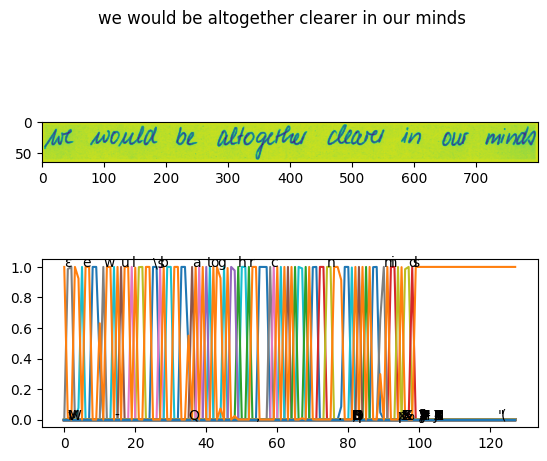

300/300 [==============================] - 17s 56ms/step - loss: 0.9722 - ctc_loss: 0.9722 - ctc_accuracy: 0.6833 - pred_CER_metric: 2.0610 - pred_WER_metric: 3.0000 - val_loss: 74.2490 - val_ctc_loss: 74.2490 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1958 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 62/200
300/300 [==============================] - 16s 54ms/step - loss: 1.0772 - ctc_loss: 1.0772 - ctc_accuracy: 0.6944 - pred_CER_metric: 2.0609 - pred_WER_metric: 3.0000 - val_loss: 77.5513 - val_ctc_loss: 77.5513 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1939 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 63/200
300/300 [==============================] - 16s 54ms/step - loss: 1.1306 - ctc_loss: 1.1306 - ctc_accuracy: 0.6600 - pred_CER_metric: 2.0616 - pred_WER_metric: 3.0000 - val_loss: 71.4488 - val_ctc_loss: 71.4488 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1997 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 64/200
300/300 [==========

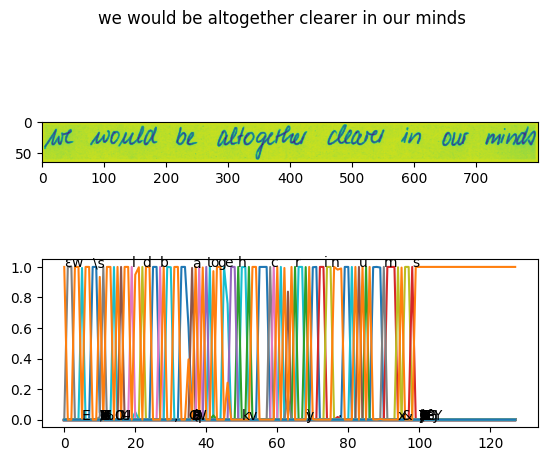

300/300 [==============================] - 17s 56ms/step - loss: 1.1616 - ctc_loss: 1.1616 - ctc_accuracy: 0.6844 - pred_CER_metric: 2.0614 - pred_WER_metric: 3.0000 - val_loss: 73.6622 - val_ctc_loss: 73.6622 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1962 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 67/200
300/300 [==============================] - 16s 54ms/step - loss: 0.9564 - ctc_loss: 0.9564 - ctc_accuracy: 0.6844 - pred_CER_metric: 2.0604 - pred_WER_metric: 3.0000 - val_loss: 72.1117 - val_ctc_loss: 72.1117 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1916 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 68/200
300/300 [==============================] - 16s 54ms/step - loss: 1.0889 - ctc_loss: 1.0889 - ctc_accuracy: 0.6989 - pred_CER_metric: 2.0605 - pred_WER_metric: 3.0000 - val_loss: 78.5114 - val_ctc_loss: 78.5114 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.2024 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 69/200
300/300 [==========

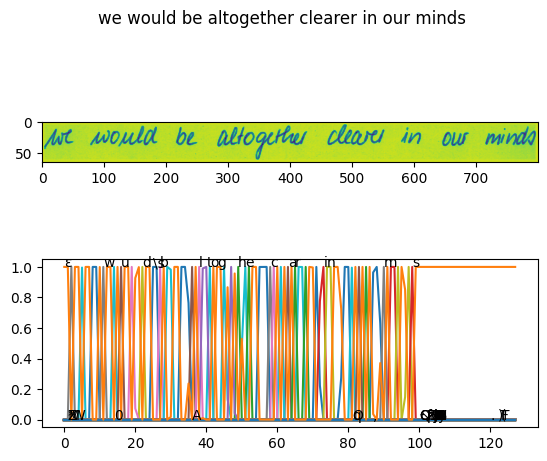

300/300 [==============================] - 17s 56ms/step - loss: 0.9322 - ctc_loss: 0.9322 - ctc_accuracy: 0.7067 - pred_CER_metric: 2.0603 - pred_WER_metric: 3.0000 - val_loss: 76.8404 - val_ctc_loss: 76.8404 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1972 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 72/200
300/300 [==============================] - 16s 54ms/step - loss: 0.8920 - ctc_loss: 0.8920 - ctc_accuracy: 0.7144 - pred_CER_metric: 2.0599 - pred_WER_metric: 3.0000 - val_loss: 70.3132 - val_ctc_loss: 70.3132 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1829 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 73/200
300/300 [==============================] - 16s 55ms/step - loss: 0.8885 - ctc_loss: 0.8885 - ctc_accuracy: 0.7133 - pred_CER_metric: 2.0603 - pred_WER_metric: 3.0000 - val_loss: 74.5482 - val_ctc_loss: 74.5482 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1836 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 74/200
300/300 [==============

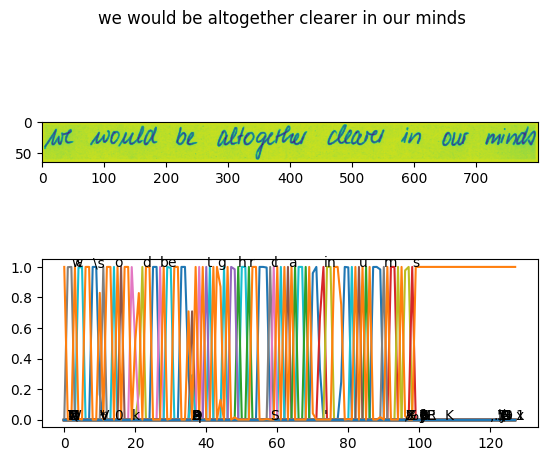

300/300 [==============================] - 17s 57ms/step - loss: 0.8877 - ctc_loss: 0.8877 - ctc_accuracy: 0.7111 - pred_CER_metric: 2.0603 - pred_WER_metric: 3.0000 - val_loss: 77.3632 - val_ctc_loss: 77.3632 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1909 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 77/200
300/300 [==============================] - 16s 54ms/step - loss: 0.8532 - ctc_loss: 0.8532 - ctc_accuracy: 0.7233 - pred_CER_metric: 2.0602 - pred_WER_metric: 3.0000 - val_loss: 75.1469 - val_ctc_loss: 75.1469 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1820 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 78/200
300/300 [==============================] - 16s 54ms/step - loss: 0.8346 - ctc_loss: 0.8346 - ctc_accuracy: 0.7444 - pred_CER_metric: 2.0595 - pred_WER_metric: 3.0000 - val_loss: 79.7688 - val_ctc_loss: 79.7688 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1868 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 79/200
300/300 [==============

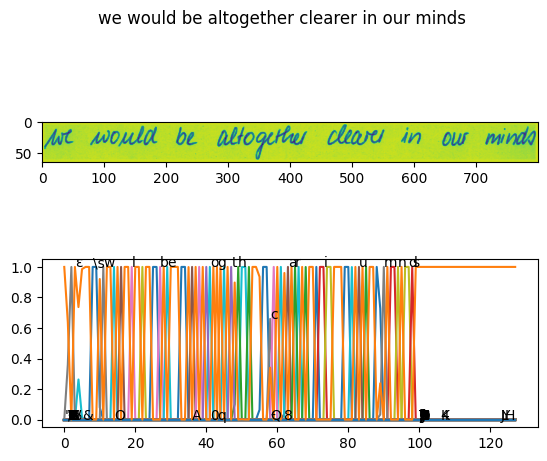

300/300 [==============================] - 17s 56ms/step - loss: 0.8984 - ctc_loss: 0.8984 - ctc_accuracy: 0.7111 - pred_CER_metric: 2.0598 - pred_WER_metric: 3.0000 - val_loss: 81.6496 - val_ctc_loss: 81.6496 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1923 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 82/200
300/300 [==============================] - 16s 54ms/step - loss: 0.9262 - ctc_loss: 0.9262 - ctc_accuracy: 0.7533 - pred_CER_metric: 2.0597 - pred_WER_metric: 3.0000 - val_loss: 76.7948 - val_ctc_loss: 76.7948 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1801 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 83/200
300/300 [==============================] - 16s 54ms/step - loss: 0.9330 - ctc_loss: 0.9330 - ctc_accuracy: 0.7300 - pred_CER_metric: 2.0596 - pred_WER_metric: 3.0000 - val_loss: 79.1136 - val_ctc_loss: 79.1136 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1847 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 84/200
300/300 [==================

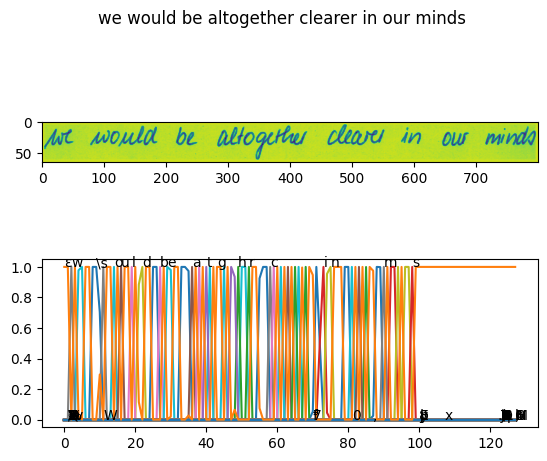

300/300 [==============================] - 17s 56ms/step - loss: 0.7009 - ctc_loss: 0.7009 - ctc_accuracy: 0.7933 - pred_CER_metric: 2.0586 - pred_WER_metric: 3.0000 - val_loss: 75.9654 - val_ctc_loss: 75.9654 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1804 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 87/200
300/300 [==============================] - 16s 54ms/step - loss: 0.7463 - ctc_loss: 0.7463 - ctc_accuracy: 0.7800 - pred_CER_metric: 2.0590 - pred_WER_metric: 3.0000 - val_loss: 79.0689 - val_ctc_loss: 79.0689 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1808 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 88/200
300/300 [==============================] - 16s 54ms/step - loss: 0.7416 - ctc_loss: 0.7416 - ctc_accuracy: 0.7922 - pred_CER_metric: 2.0587 - pred_WER_metric: 3.0000 - val_loss: 75.4525 - val_ctc_loss: 75.4525 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1857 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 89/200
300/300 [==============

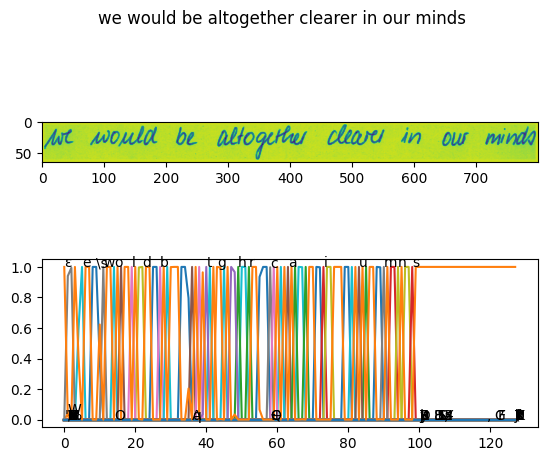

300/300 [==============================] - 17s 57ms/step - loss: 0.7995 - ctc_loss: 0.7995 - ctc_accuracy: 0.7844 - pred_CER_metric: 2.0589 - pred_WER_metric: 3.0000 - val_loss: 78.2423 - val_ctc_loss: 78.2423 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1831 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 92/200
300/300 [==============================] - 16s 54ms/step - loss: 0.6876 - ctc_loss: 0.6876 - ctc_accuracy: 0.7989 - pred_CER_metric: 2.0584 - pred_WER_metric: 3.0000 - val_loss: 79.1657 - val_ctc_loss: 79.1657 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1772 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 93/200
300/300 [==============================] - 16s 55ms/step - loss: 0.7414 - ctc_loss: 0.7414 - ctc_accuracy: 0.8000 - pred_CER_metric: 2.0587 - pred_WER_metric: 3.0000 - val_loss: 78.6229 - val_ctc_loss: 78.6229 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1891 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 94/200
300/300 [======================

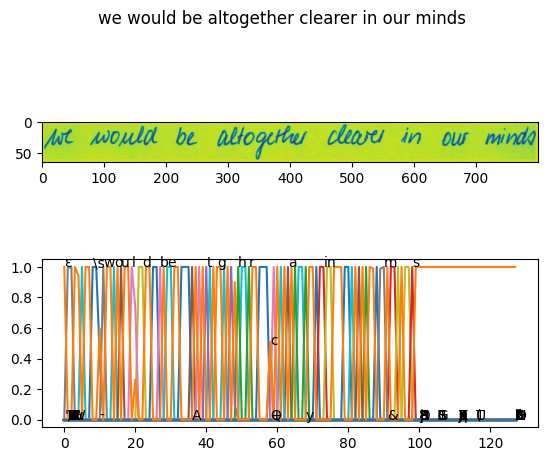

300/300 [==============================] - 17s 57ms/step - loss: 0.7360 - ctc_loss: 0.7360 - ctc_accuracy: 0.8011 - pred_CER_metric: 2.0588 - pred_WER_metric: 3.0000 - val_loss: 80.0105 - val_ctc_loss: 80.0105 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1939 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 97/200
300/300 [==============================] - 16s 55ms/step - loss: 0.6990 - ctc_loss: 0.6990 - ctc_accuracy: 0.8089 - pred_CER_metric: 2.0586 - pred_WER_metric: 3.0000 - val_loss: 79.1092 - val_ctc_loss: 79.1092 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1808 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 98/200
300/300 [==============================] - 16s 55ms/step - loss: 0.7221 - ctc_loss: 0.7221 - ctc_accuracy: 0.7744 - pred_CER_metric: 2.0593 - pred_WER_metric: 3.0000 - val_loss: 73.0283 - val_ctc_loss: 73.0283 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1739 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 99/200
300/300 [==================

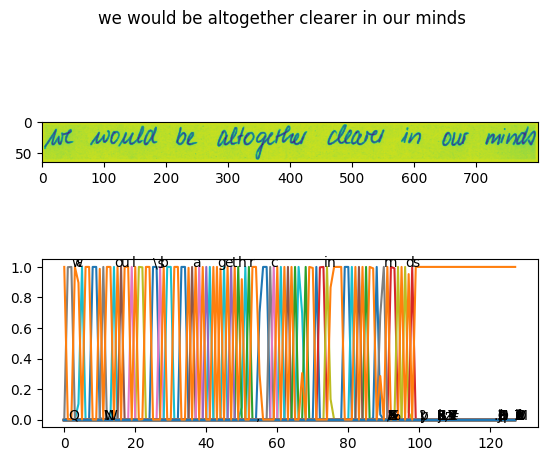

300/300 [==============================] - 17s 56ms/step - loss: 0.6806 - ctc_loss: 0.6806 - ctc_accuracy: 0.7989 - pred_CER_metric: 2.0587 - pred_WER_metric: 3.0000 - val_loss: 82.1827 - val_ctc_loss: 82.1827 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1912 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 102/200
300/300 [==============================] - 16s 54ms/step - loss: 0.7156 - ctc_loss: 0.7156 - ctc_accuracy: 0.8067 - pred_CER_metric: 2.0586 - pred_WER_metric: 3.0000 - val_loss: 85.2774 - val_ctc_loss: 85.2774 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1907 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 103/200
300/300 [==============================] - 16s 54ms/step - loss: 0.5916 - ctc_loss: 0.5916 - ctc_accuracy: 0.8111 - pred_CER_metric: 2.0582 - pred_WER_metric: 3.0000 - val_loss: 83.3571 - val_ctc_loss: 83.3571 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1935 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 104/200
300/300 [===========

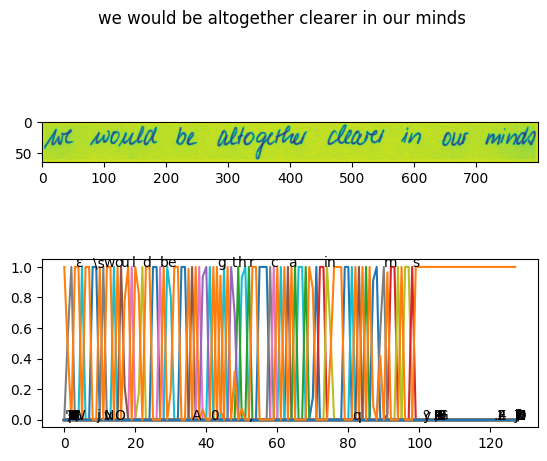

300/300 [==============================] - 17s 56ms/step - loss: 0.5878 - ctc_loss: 0.5878 - ctc_accuracy: 0.8333 - pred_CER_metric: 2.0578 - pred_WER_metric: 3.0000 - val_loss: 78.8000 - val_ctc_loss: 78.8000 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1873 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 107/200
300/300 [==============================] - 16s 54ms/step - loss: 0.6117 - ctc_loss: 0.6117 - ctc_accuracy: 0.8356 - pred_CER_metric: 2.0578 - pred_WER_metric: 3.0000 - val_loss: 84.2292 - val_ctc_loss: 84.2292 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1859 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 108/200
300/300 [==============================] - 16s 54ms/step - loss: 0.7880 - ctc_loss: 0.7880 - ctc_accuracy: 0.7800 - pred_CER_metric: 2.0589 - pred_WER_metric: 3.0000 - val_loss: 81.5870 - val_ctc_loss: 81.5870 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1804 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 109/200
300/300 [===============

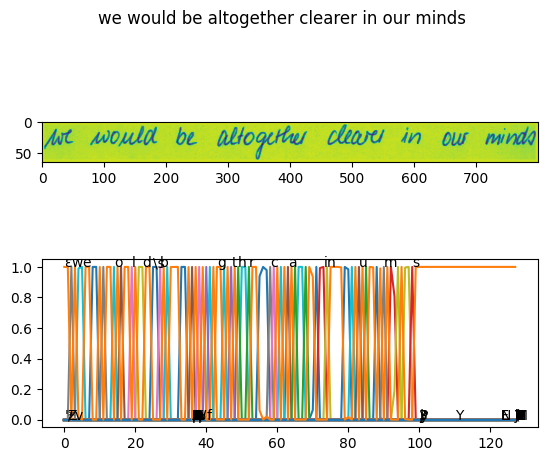

300/300 [==============================] - 17s 56ms/step - loss: 0.6751 - ctc_loss: 0.6751 - ctc_accuracy: 0.8144 - pred_CER_metric: 2.0582 - pred_WER_metric: 3.0000 - val_loss: 78.4554 - val_ctc_loss: 78.4554 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1815 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 112/200
300/300 [==============================] - 16s 55ms/step - loss: 0.6553 - ctc_loss: 0.6553 - ctc_accuracy: 0.8267 - pred_CER_metric: 2.0579 - pred_WER_metric: 3.0000 - val_loss: 80.2520 - val_ctc_loss: 80.2520 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1804 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 113/200
300/300 [==============================] - 16s 54ms/step - loss: 0.6337 - ctc_loss: 0.6337 - ctc_accuracy: 0.8200 - pred_CER_metric: 2.0578 - pred_WER_metric: 3.0000 - val_loss: 81.8502 - val_ctc_loss: 81.8502 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1875 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 114/200
300/300 [===========

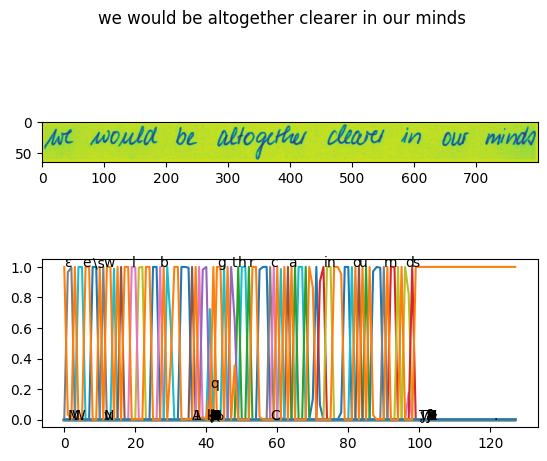

300/300 [==============================] - 17s 56ms/step - loss: 0.5622 - ctc_loss: 0.5622 - ctc_accuracy: 0.8233 - pred_CER_metric: 2.0580 - pred_WER_metric: 3.0000 - val_loss: 87.6618 - val_ctc_loss: 87.6618 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.2057 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 117/200
300/300 [==============================] - 16s 55ms/step - loss: 0.6478 - ctc_loss: 0.6478 - ctc_accuracy: 0.8100 - pred_CER_metric: 2.0582 - pred_WER_metric: 3.0000 - val_loss: 81.3410 - val_ctc_loss: 81.3410 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1824 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 118/200
300/300 [==============================] - 17s 55ms/step - loss: 0.6107 - ctc_loss: 0.6107 - ctc_accuracy: 0.8089 - pred_CER_metric: 2.0584 - pred_WER_metric: 3.0000 - val_loss: 82.9285 - val_ctc_loss: 82.9285 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1965 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 119/200
300/300 [===============

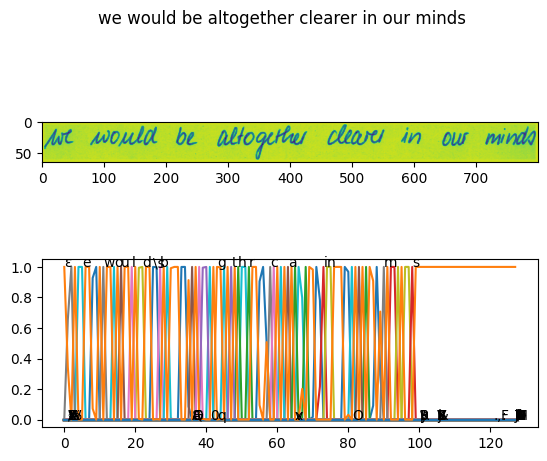

300/300 [==============================] - 17s 57ms/step - loss: 0.6562 - ctc_loss: 0.6562 - ctc_accuracy: 0.8244 - pred_CER_metric: 2.0580 - pred_WER_metric: 3.0000 - val_loss: 76.7799 - val_ctc_loss: 76.7799 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1795 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 122/200
300/300 [==============================] - 16s 55ms/step - loss: 0.6658 - ctc_loss: 0.6658 - ctc_accuracy: 0.8133 - pred_CER_metric: 2.0584 - pred_WER_metric: 3.0000 - val_loss: 83.1255 - val_ctc_loss: 83.1255 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1866 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 123/200
300/300 [==============================] - 17s 55ms/step - loss: 0.5335 - ctc_loss: 0.5335 - ctc_accuracy: 0.8556 - pred_CER_metric: 2.0576 - pred_WER_metric: 3.0000 - val_loss: 81.8187 - val_ctc_loss: 81.8187 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1859 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 124/200
300/300 [=======

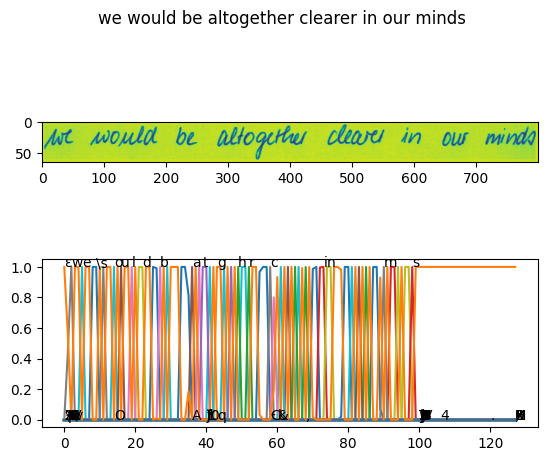

300/300 [==============================] - 17s 56ms/step - loss: 0.5064 - ctc_loss: 0.5064 - ctc_accuracy: 0.8633 - pred_CER_metric: 2.0574 - pred_WER_metric: 3.0000 - val_loss: 78.7134 - val_ctc_loss: 78.7134 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1753 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 127/200
300/300 [==============================] - 16s 55ms/step - loss: 0.6202 - ctc_loss: 0.6202 - ctc_accuracy: 0.8322 - pred_CER_metric: 2.0580 - pred_WER_metric: 3.0000 - val_loss: 83.0495 - val_ctc_loss: 83.0495 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1923 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 128/200
300/300 [==============================] - 16s 54ms/step - loss: 0.6085 - ctc_loss: 0.6085 - ctc_accuracy: 0.8489 - pred_CER_metric: 2.0579 - pred_WER_metric: 3.0000 - val_loss: 84.9219 - val_ctc_loss: 84.9219 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1889 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 129/200
300/300 [===============

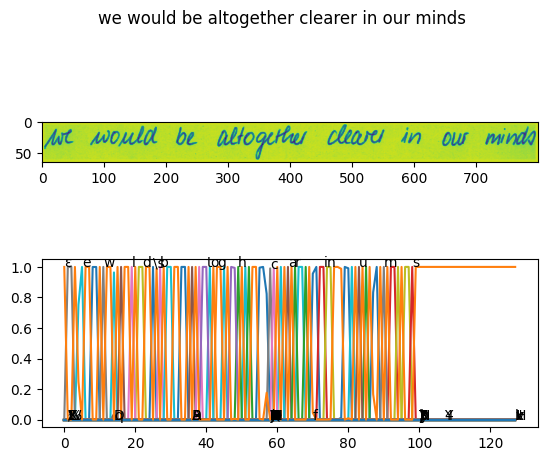

300/300 [==============================] - 17s 56ms/step - loss: 0.5328 - ctc_loss: 0.5328 - ctc_accuracy: 0.8489 - pred_CER_metric: 2.0573 - pred_WER_metric: 3.0000 - val_loss: 82.2229 - val_ctc_loss: 82.2229 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1882 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 132/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4728 - ctc_loss: 0.4728 - ctc_accuracy: 0.8633 - pred_CER_metric: 2.0572 - pred_WER_metric: 3.0000 - val_loss: 84.2328 - val_ctc_loss: 84.2328 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1854 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 133/200
300/300 [==============================] - 16s 55ms/step - loss: 0.5144 - ctc_loss: 0.5144 - ctc_accuracy: 0.8600 - pred_CER_metric: 2.0573 - pred_WER_metric: 3.0000 - val_loss: 82.5282 - val_ctc_loss: 82.5282 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1880 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 134/200
300/300 [===========

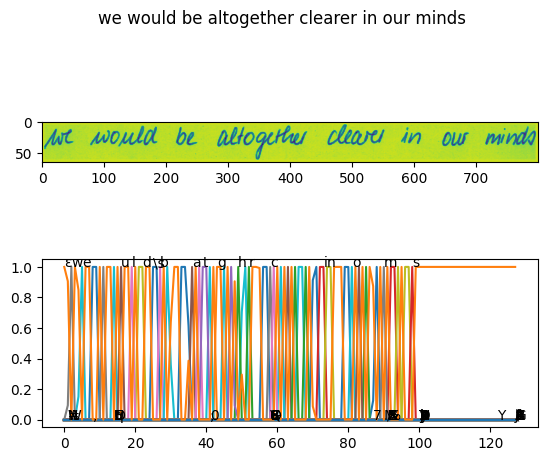

300/300 [==============================] - 17s 56ms/step - loss: 0.5294 - ctc_loss: 0.5294 - ctc_accuracy: 0.8333 - pred_CER_metric: 2.0578 - pred_WER_metric: 3.0000 - val_loss: 80.6036 - val_ctc_loss: 80.6036 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1829 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 137/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4811 - ctc_loss: 0.4811 - ctc_accuracy: 0.8722 - pred_CER_metric: 2.0571 - pred_WER_metric: 3.0000 - val_loss: 83.7003 - val_ctc_loss: 83.7003 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1838 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 138/200
300/300 [==============================] - 16s 54ms/step - loss: 0.5036 - ctc_loss: 0.5036 - ctc_accuracy: 0.8611 - pred_CER_metric: 2.0577 - pred_WER_metric: 3.0000 - val_loss: 84.1128 - val_ctc_loss: 84.1128 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1866 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 139/200
300/300 [===========

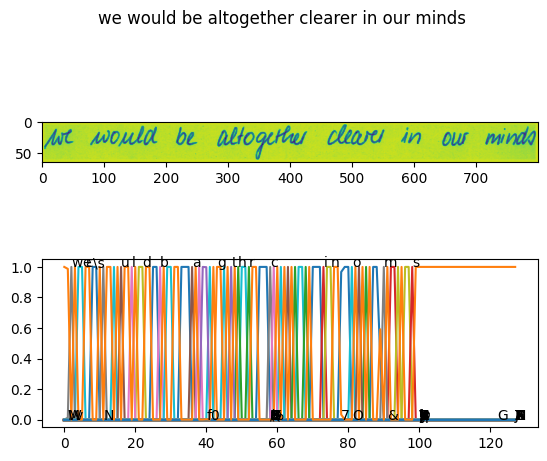

300/300 [==============================] - 17s 56ms/step - loss: 0.4304 - ctc_loss: 0.4304 - ctc_accuracy: 0.8722 - pred_CER_metric: 2.0569 - pred_WER_metric: 3.0000 - val_loss: 85.0817 - val_ctc_loss: 85.0817 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1891 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 142/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4797 - ctc_loss: 0.4797 - ctc_accuracy: 0.8644 - pred_CER_metric: 2.0574 - pred_WER_metric: 3.0000 - val_loss: 84.6579 - val_ctc_loss: 84.6579 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1875 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 143/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4661 - ctc_loss: 0.4661 - ctc_accuracy: 0.8611 - pred_CER_metric: 2.0572 - pred_WER_metric: 3.0000 - val_loss: 85.2966 - val_ctc_loss: 85.2966 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1942 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 144/200
300/300 [===================

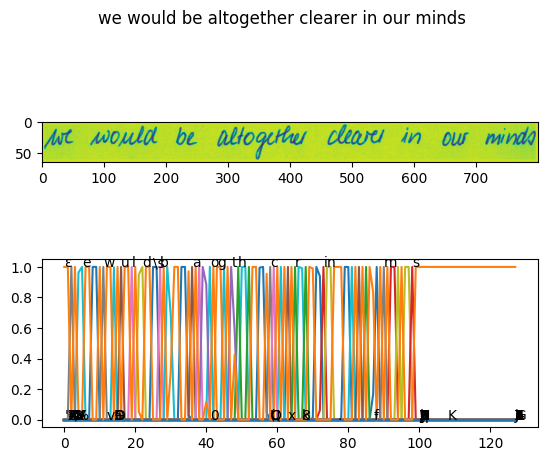

300/300 [==============================] - 17s 56ms/step - loss: 0.5969 - ctc_loss: 0.5969 - ctc_accuracy: 0.8367 - pred_CER_metric: 2.0578 - pred_WER_metric: 3.0000 - val_loss: 82.5446 - val_ctc_loss: 82.5446 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1889 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 147/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4994 - ctc_loss: 0.4994 - ctc_accuracy: 0.8644 - pred_CER_metric: 2.0573 - pred_WER_metric: 3.0000 - val_loss: 86.7307 - val_ctc_loss: 86.7307 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1898 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 148/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4901 - ctc_loss: 0.4901 - ctc_accuracy: 0.8800 - pred_CER_metric: 2.0568 - pred_WER_metric: 3.0000 - val_loss: 87.4326 - val_ctc_loss: 87.4326 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1905 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 149/200
300/300 [=======

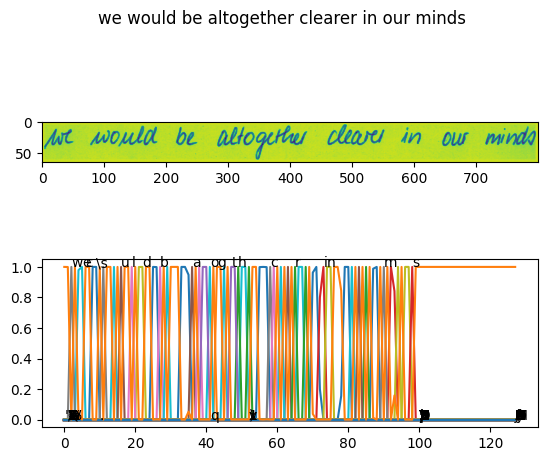

300/300 [==============================] - 17s 56ms/step - loss: 0.4697 - ctc_loss: 0.4697 - ctc_accuracy: 0.8689 - pred_CER_metric: 2.0571 - pred_WER_metric: 3.0000 - val_loss: 85.7100 - val_ctc_loss: 85.7100 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1836 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 152/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4706 - ctc_loss: 0.4706 - ctc_accuracy: 0.8600 - pred_CER_metric: 2.0572 - pred_WER_metric: 3.0000 - val_loss: 81.0847 - val_ctc_loss: 81.0847 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1799 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 153/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4636 - ctc_loss: 0.4636 - ctc_accuracy: 0.8844 - pred_CER_metric: 2.0568 - pred_WER_metric: 3.0000 - val_loss: 81.5051 - val_ctc_loss: 81.5051 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1788 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 154/200
300/300 [===================

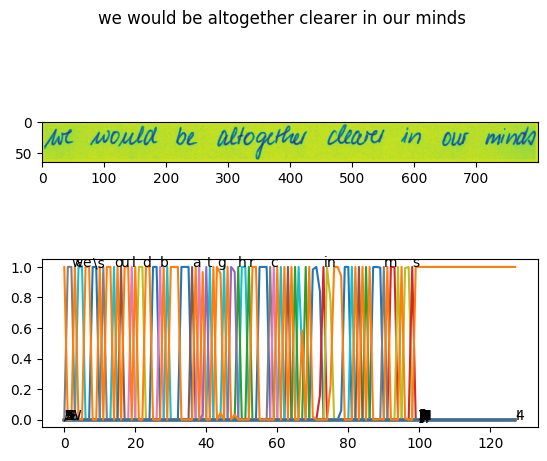

300/300 [==============================] - 17s 57ms/step - loss: 0.3845 - ctc_loss: 0.3845 - ctc_accuracy: 0.8911 - pred_CER_metric: 2.0567 - pred_WER_metric: 3.0000 - val_loss: 91.3815 - val_ctc_loss: 91.3815 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1896 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 157/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4946 - ctc_loss: 0.4946 - ctc_accuracy: 0.8567 - pred_CER_metric: 2.0575 - pred_WER_metric: 3.0000 - val_loss: 88.4575 - val_ctc_loss: 88.4575 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1905 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 158/200
300/300 [==============================] - 16s 54ms/step - loss: 0.5004 - ctc_loss: 0.5004 - ctc_accuracy: 0.8644 - pred_CER_metric: 2.0573 - pred_WER_metric: 3.0000 - val_loss: 86.9184 - val_ctc_loss: 86.9184 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1801 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 159/200
300/300 [===============

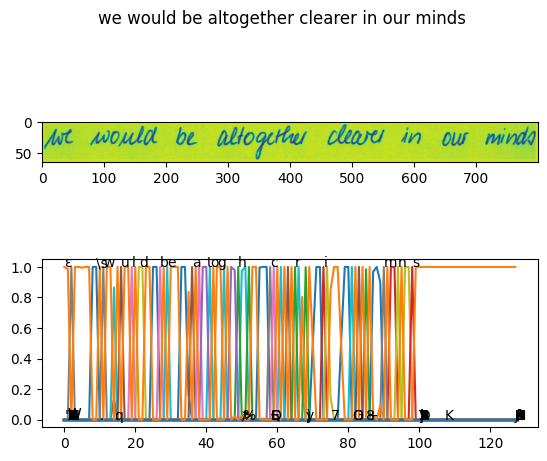

300/300 [==============================] - 18s 60ms/step - loss: 0.3345 - ctc_loss: 0.3345 - ctc_accuracy: 0.9011 - pred_CER_metric: 2.0563 - pred_WER_metric: 3.0000 - val_loss: 92.9142 - val_ctc_loss: 92.9142 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1942 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 162/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3767 - ctc_loss: 0.3767 - ctc_accuracy: 0.9122 - pred_CER_metric: 2.0564 - pred_WER_metric: 3.0000 - val_loss: 84.7339 - val_ctc_loss: 84.7339 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1829 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 163/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4377 - ctc_loss: 0.4377 - ctc_accuracy: 0.8833 - pred_CER_metric: 2.0570 - pred_WER_metric: 3.0000 - val_loss: 87.0690 - val_ctc_loss: 87.0690 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1822 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 164/200
300/300 [===========

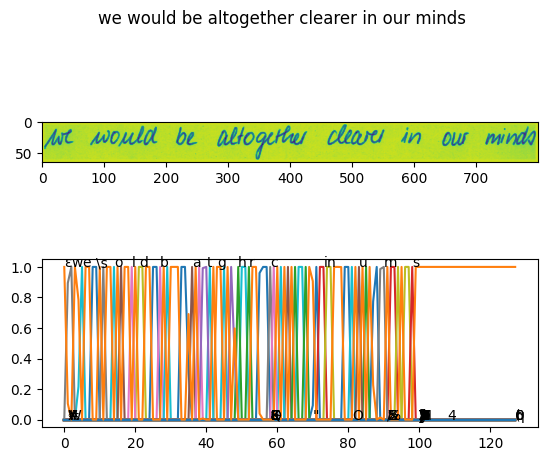

300/300 [==============================] - 17s 56ms/step - loss: 0.3436 - ctc_loss: 0.3436 - ctc_accuracy: 0.9056 - pred_CER_metric: 2.0563 - pred_WER_metric: 3.0000 - val_loss: 85.8279 - val_ctc_loss: 85.8279 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1797 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 167/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4203 - ctc_loss: 0.4203 - ctc_accuracy: 0.8878 - pred_CER_metric: 2.0569 - pred_WER_metric: 3.0000 - val_loss: 87.6012 - val_ctc_loss: 87.6012 - val_ctc_accuracy: 0.0200 - val_pred_CER_metric: 2.1831 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 168/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4251 - ctc_loss: 0.4251 - ctc_accuracy: 0.8944 - pred_CER_metric: 2.0569 - pred_WER_metric: 3.0000 - val_loss: 89.6395 - val_ctc_loss: 89.6395 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1907 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 169/200
300/300 [===========

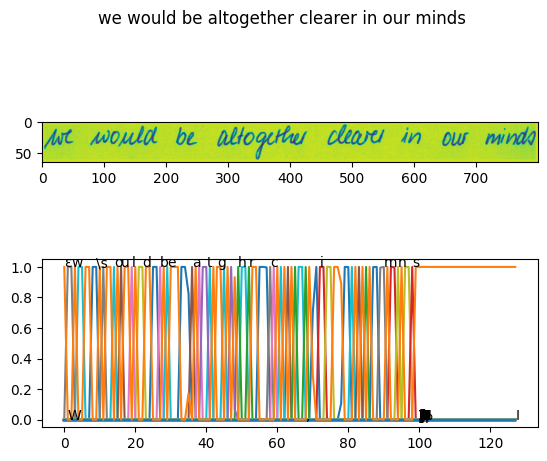

300/300 [==============================] - 17s 56ms/step - loss: 0.3337 - ctc_loss: 0.3337 - ctc_accuracy: 0.9144 - pred_CER_metric: 2.0563 - pred_WER_metric: 3.0000 - val_loss: 87.6850 - val_ctc_loss: 87.6850 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1870 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 172/200
300/300 [==============================] - 16s 55ms/step - loss: 0.2953 - ctc_loss: 0.2953 - ctc_accuracy: 0.9111 - pred_CER_metric: 2.0562 - pred_WER_metric: 3.0000 - val_loss: 88.7921 - val_ctc_loss: 88.7921 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1870 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 173/200
300/300 [==============================] - 16s 54ms/step - loss: 0.5047 - ctc_loss: 0.5047 - ctc_accuracy: 0.8722 - pred_CER_metric: 2.0572 - pred_WER_metric: 3.0000 - val_loss: 90.3242 - val_ctc_loss: 90.3242 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1866 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 174/200
300/300 [===============

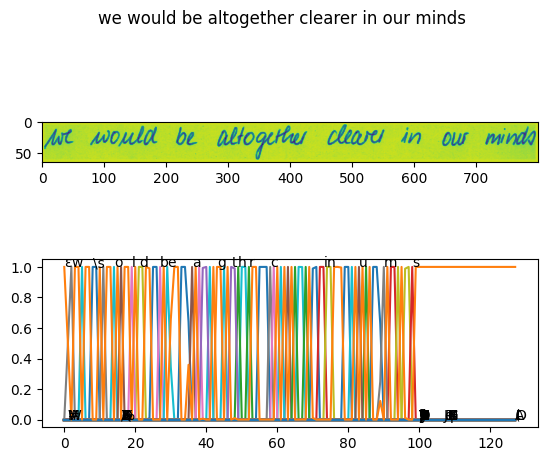

300/300 [==============================] - 17s 57ms/step - loss: 0.3528 - ctc_loss: 0.3528 - ctc_accuracy: 0.9022 - pred_CER_metric: 2.0563 - pred_WER_metric: 3.0000 - val_loss: 86.0449 - val_ctc_loss: 86.0449 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1790 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 177/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4230 - ctc_loss: 0.4230 - ctc_accuracy: 0.8900 - pred_CER_metric: 2.0566 - pred_WER_metric: 3.0000 - val_loss: 86.4079 - val_ctc_loss: 86.4079 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1829 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 178/200
300/300 [==============================] - 16s 55ms/step - loss: 0.4709 - ctc_loss: 0.4709 - ctc_accuracy: 0.8744 - pred_CER_metric: 2.0571 - pred_WER_metric: 3.0000 - val_loss: 85.3725 - val_ctc_loss: 85.3725 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1822 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 179/200
300/300 [===========

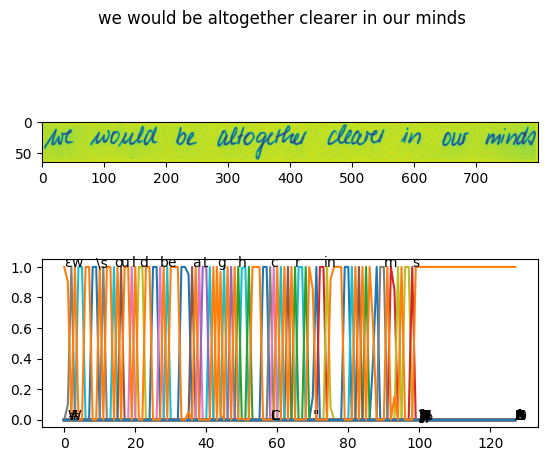

300/300 [==============================] - 17s 56ms/step - loss: 0.5285 - ctc_loss: 0.5285 - ctc_accuracy: 0.8678 - pred_CER_metric: 2.0571 - pred_WER_metric: 3.0000 - val_loss: 83.7142 - val_ctc_loss: 83.7142 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1795 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 182/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4296 - ctc_loss: 0.4296 - ctc_accuracy: 0.8922 - pred_CER_metric: 2.0570 - pred_WER_metric: 3.0000 - val_loss: 84.5732 - val_ctc_loss: 84.5732 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1788 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 183/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3859 - ctc_loss: 0.3859 - ctc_accuracy: 0.9067 - pred_CER_metric: 2.0564 - pred_WER_metric: 3.0000 - val_loss: 87.7994 - val_ctc_loss: 87.7994 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1811 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 184/200
300/300 [===========

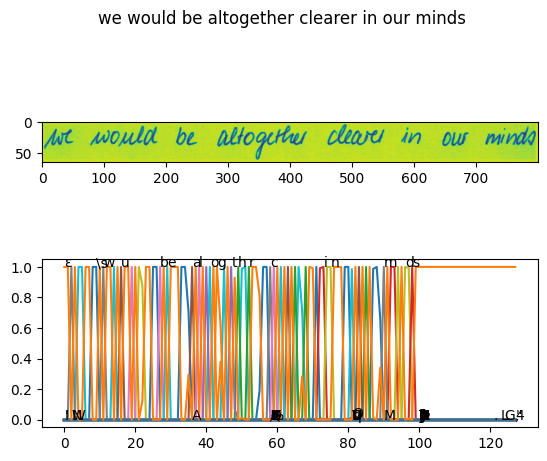

300/300 [==============================] - 17s 56ms/step - loss: 0.4152 - ctc_loss: 0.4152 - ctc_accuracy: 0.8911 - pred_CER_metric: 2.0568 - pred_WER_metric: 3.0000 - val_loss: 88.6799 - val_ctc_loss: 88.6799 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1907 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 187/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3693 - ctc_loss: 0.3693 - ctc_accuracy: 0.8978 - pred_CER_metric: 2.0567 - pred_WER_metric: 3.0000 - val_loss: 87.1370 - val_ctc_loss: 87.1370 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1909 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 188/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3855 - ctc_loss: 0.3855 - ctc_accuracy: 0.9111 - pred_CER_metric: 2.0563 - pred_WER_metric: 3.0000 - val_loss: 87.9291 - val_ctc_loss: 87.9291 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1882 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 189/200
300/300 [===================

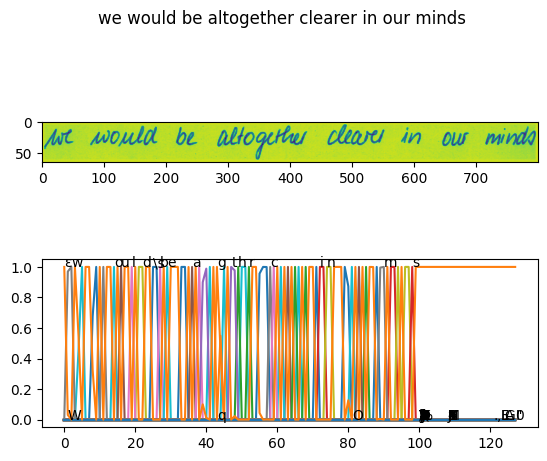

300/300 [==============================] - 17s 56ms/step - loss: 0.3589 - ctc_loss: 0.3589 - ctc_accuracy: 0.9067 - pred_CER_metric: 2.0567 - pred_WER_metric: 3.0000 - val_loss: 83.7771 - val_ctc_loss: 83.7771 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1847 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 192/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3646 - ctc_loss: 0.3646 - ctc_accuracy: 0.9000 - pred_CER_metric: 2.0564 - pred_WER_metric: 3.0000 - val_loss: 90.8579 - val_ctc_loss: 90.8579 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1868 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 193/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3876 - ctc_loss: 0.3876 - ctc_accuracy: 0.8944 - pred_CER_metric: 2.0567 - pred_WER_metric: 3.0000 - val_loss: 87.5879 - val_ctc_loss: 87.5879 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1850 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 194/200
300/300 [===============

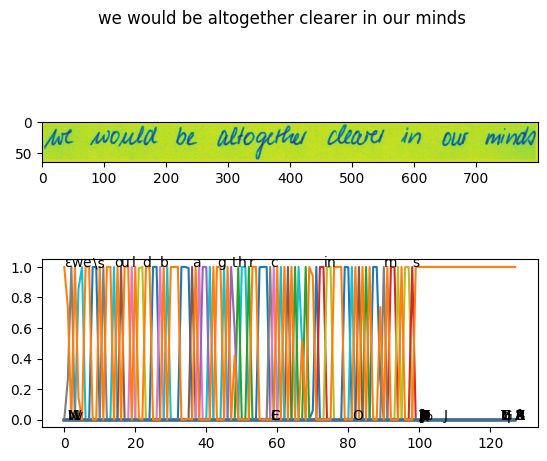

300/300 [==============================] - 17s 57ms/step - loss: 0.3958 - ctc_loss: 0.3958 - ctc_accuracy: 0.9056 - pred_CER_metric: 2.0565 - pred_WER_metric: 3.0000 - val_loss: 85.9317 - val_ctc_loss: 85.9317 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1762 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 197/200
300/300 [==============================] - 16s 54ms/step - loss: 0.4056 - ctc_loss: 0.4056 - ctc_accuracy: 0.8956 - pred_CER_metric: 2.0567 - pred_WER_metric: 3.0000 - val_loss: 85.2350 - val_ctc_loss: 85.2350 - val_ctc_accuracy: 0.0000e+00 - val_pred_CER_metric: 2.1799 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 198/200
300/300 [==============================] - 16s 54ms/step - loss: 0.3948 - ctc_loss: 0.3948 - ctc_accuracy: 0.8967 - pred_CER_metric: 2.0566 - pred_WER_metric: 3.0000 - val_loss: 86.1698 - val_ctc_loss: 86.1698 - val_ctc_accuracy: 0.0100 - val_pred_CER_metric: 2.1781 - val_pred_WER_metric: 2.9412 - lr: 0.0010
Epoch 199/200
300/300 [===========

In [93]:
lim=1000
history = train_model.fit([x_train[:lim], y_true[:lim], y_len[:lim], logit_len[:lim]], [y_train[:lim], y_true_categorical[:lim]], 
                          validation_split=0.1, 
                          shuffle=True, 
                          epochs=200,
                          batch_size=3,
                          callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.6, patience=3, min_lr=0.001, mode="min", verbose=1),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=callback_plot)
])

### Measuring performance

In [94]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name], label=metric_name)
    plt.plot(history.history[f'val_{metric_name}'], label=f"val_{metric_name}")
    plt.legend()
    plt.show()

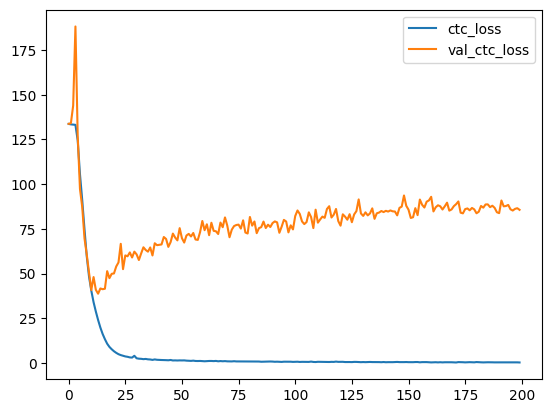

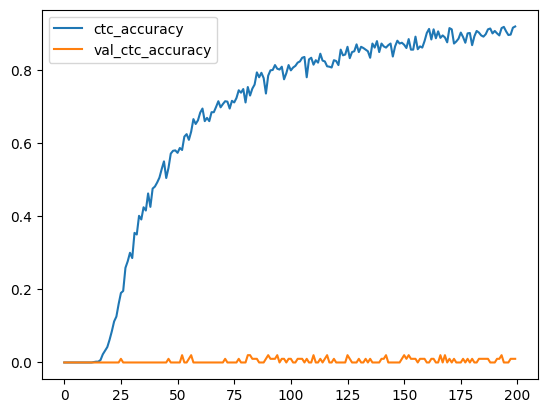

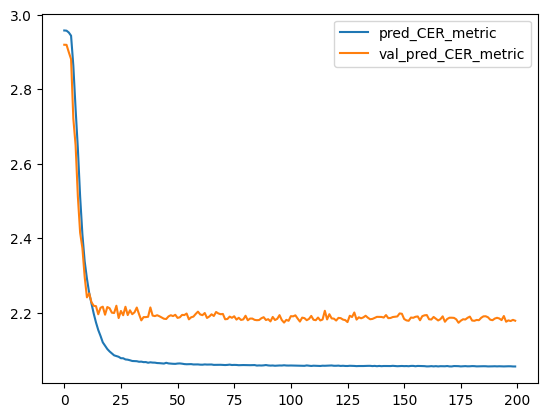

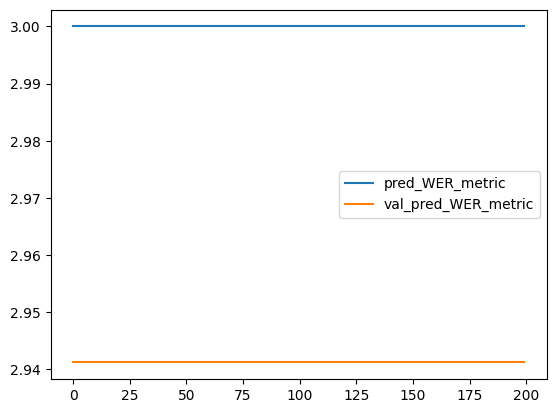

In [95]:
plot_metric("ctc_loss")
plot_metric("ctc_accuracy")
plot_metric("pred_CER_metric")
plot_metric("pred_WER_metric")

### Seeing some predictions

1/1 [==============================] - 0s 23ms/step
(5, 128, 82)


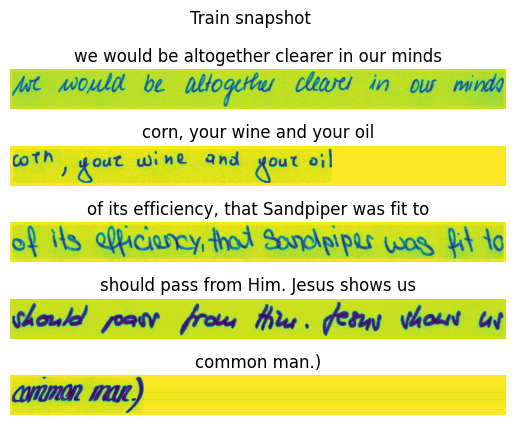

1/1 [==============================] - 0s 26ms/step
(5, 128, 82)


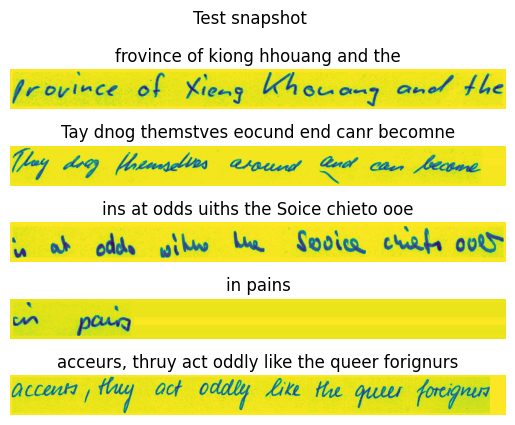

In [113]:
def preview_output(x, yt, title):
    y = recognition_model.predict(x)
    print(y.shape)
    y, _ = tf.keras.backend.ctc_decode(y, np.array([SEQ_LEN]*y.shape[0]), greedy=True)
    y=y[0].numpy()        
    n = x.shape[0]
    fig, axs = plt.subplots(n)
    fig.suptitle(title)    

    for i in range(n):
        axs[i].imshow(x[i])
        real_text = "".join([characters[c] for c in y[i] if 0<=c<len(characters)])        
        axs[i].set_title(f"{real_text}")
        axs[i].axis('off')
    plt.show()
    
preview_output(x_train[:5], y_true[:5], "Train snapshot")
preview_output(x_train[995:1000], y_true[995:1000], "Test snapshot")


### For good measures

In [115]:
recognition_model.save_weights("model_crnn_lstm_weights.h5")
recognition_model.save("model_crnn_lstm.keras")